In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
# import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from IPython.display import Image
from theano.compile.ops import as_op
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

color = '#87ceeb'
f_dict = {'size':14}

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def class_label(z, mu):
    y = np.zeros((z.shape[0], 1))

    for i, zz in enumerate(z):
        if (zz <= mu[0]):
            y[i, 0] = 0
            #D1[i, 0] = 1
        elif (zz > mu[0]) & (zz <= mu[1]):
            y[i, 0] = 1
            #D2[i, 0] = 1
        elif (zz > mu[1]) & (zz <= mu[2]):
            y[i, 0] = 2
            #D3[i, 0] = 1
        else:
            y[i, 0] = 3
            #D4[i, 0] = 1

    return y

In [4]:
# True parameter values
sigma = 1
beta = np.array([-35, -10, 15, -3])
mu = np.array([0, 5,  15])
# Size of dataset
size = 2000

# Predictor variable
X0 = np.ones((size, 1))
X1 = np.linspace(-5, 1, size).reshape(-1,1)
X2 = np.linspace(0, 3.5, size).reshape(-1,1)
X3 = np.linspace(-2, 3.5, size).reshape(-1,1)
X = np.concatenate([X0, X1, X2, X3], axis=1)


# Simulate outcome variable
z = X.dot(beta)+np.random.randn(size) * sigma #alpha + beta[0] * X1 + beta[1] * X2 + 

(array([129., 215., 231., 232., 214., 227., 232., 223., 222.,  75.]),
 array([-4.31904618, -1.58872291,  1.14160036,  3.87192363,  6.6022469 ,
         9.33257017, 12.06289344, 14.79321672, 17.52353999, 20.25386326,
        22.98418653]),
 <a list of 10 Patch objects>)

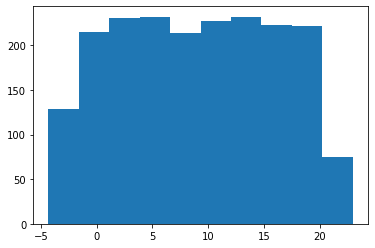

In [5]:
plt.hist(z)

(array([247.,   0.,   0., 426.,   0.,   0., 825.,   0.,   0., 502.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

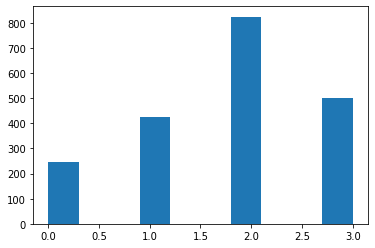

In [6]:
y = class_label(z, mu)
plt.hist(y)

In [7]:
# Number of outcomes
nYlevels = 4
Ncases = y.shape[0]
gammaShRa = gammaShRaFromModeSD(3, 3)

print(Ncases)
print(nYlevels)
print(gammaShRa)

2000
4
(2.618033988749895, 0.5393446629166316)


In [21]:
# Ordered logistic regression
with pm.Model() as model:
    
    # beta = pm.Normal("beta", mu=[-35, -10, 15, -3], sd=2, shape=4)
    # cutpoints = pm.Normal("cutpoints", mu=[0, 5, 15], sigma=4, shape=3,
    #                    transform=pm.distributions.transforms.ordered)
    
    beta = pm.Laplace("beta", mu=[-35, -10, 15, -3], b=.5, shape=4)
    cutpoints = pm.Laplace("cutpoints", mu=[0, 5, 15], b=.5, shape=3,
                        transform=pm.distributions.transforms.ordered)

    # Expected value of outcome
    mu = beta[0] + beta[1] * X1 + beta[2] * X2 + beta[3] * X3
    # mu = pm.Deterministic('mu', tt.dot(X, beta))
    
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=y)

In [22]:
with model: 
    #step1 = pm.Metropolis([cutpoints])
    step = pm.NUTS(target_accept=0.8)
    trace = pm.sample(2500, tune = 2000, progressbar=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [19:41<00:00, 15.23draws/s]


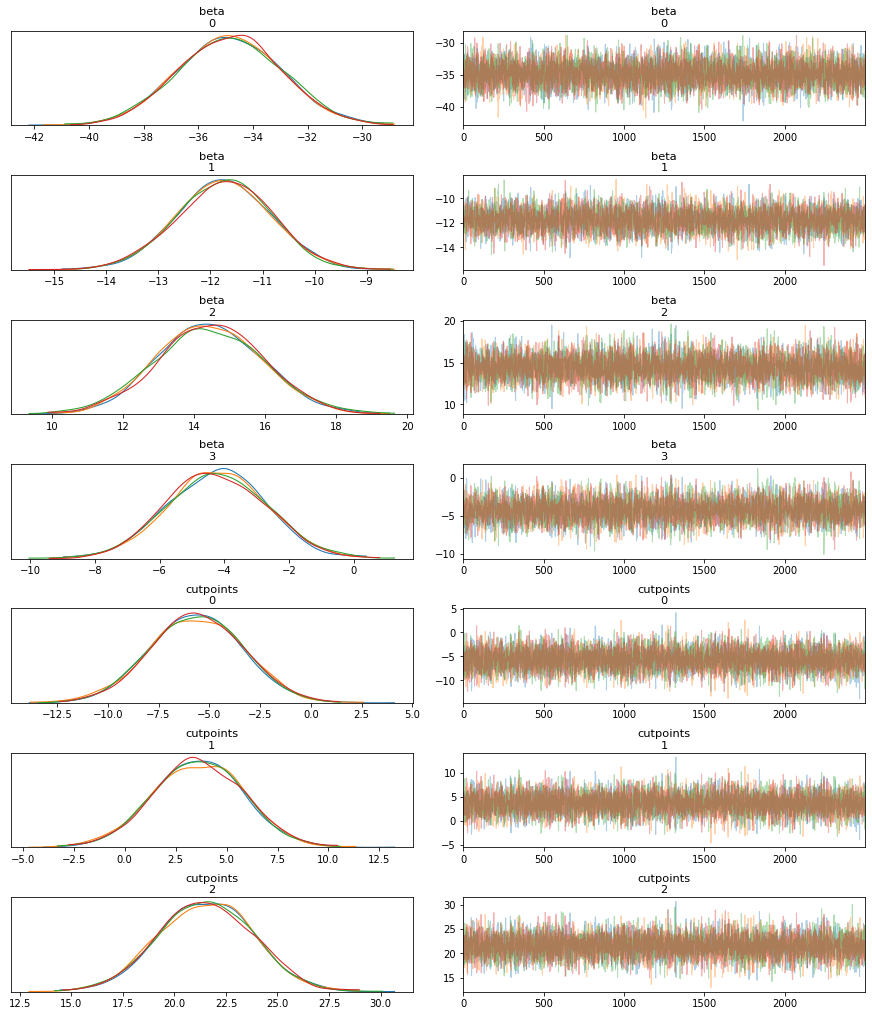

In [10]:
fig1 = pm.traceplot(trace, compact=False)

In [11]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],-34.870,1.876,-38.429,-31.395,0.022,0.015,7357.0,7346.0,7345.0,6101.0,1.0
beta[1],-11.751,0.896,-13.381,-10.004,0.012,0.009,5449.0,5449.0,5446.0,5538.0,1.0
beta[2],14.426,1.476,11.663,17.224,0.019,0.014,5870.0,5840.0,5868.0,5477.0,1.0
beta[3],-4.255,1.512,-7.152,-1.532,0.020,0.015,5446.0,5284.0,5444.0,5391.0,1.0
cutpoints[0],-5.663,2.253,-9.880,-1.458,0.028,0.020,6523.0,6523.0,6511.0,6015.0,1.0
cutpoints[1],3.593,2.184,-0.467,7.728,0.027,0.020,6786.0,6138.0,6784.0,5965.0,1.0
cutpoints[2],21.496,2.269,17.341,25.818,0.028,0.020,6738.0,6730.0,6736.0,6320.0,1.0


In [12]:
ppc = pm.sample_ppc(trace, samples=5000, model=model, size=1)

100%|██████████| 5000/5000 [05:00<00:00, 16.62it/s]


In [13]:
y_pred_samps = ppc['y']
y_pred = np.zeros(y_pred_samps.shape[1])

In [14]:
y_pred_samps.shape

(5000, 2000, 1)

In [15]:
for i in range(0, len(y)):

    p1 = np.mean(y_pred_samps[:,i] == 0)
    p2 = np.mean(y_pred_samps[:,i] == 1)
    p3 = np.mean(y_pred_samps[:,i] == 2)
    p4 = np.mean(y_pred_samps[:,i] == 3)
    probs = [p1, p2, p3, p4]
    
    y_pred[i] = probs.index(max(probs))

In [16]:
probs

[0.996, 0.004, 0.0, 0.0]

(array([247.,   0.,   0., 426.,   0.,   0., 825.,   0.,   0., 502.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

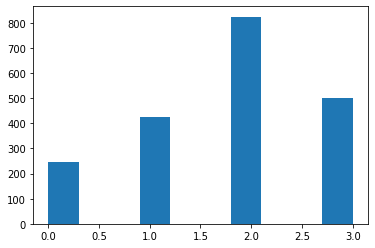

In [17]:
plt.hist(y)

(array([246.,   0.,   0., 428.,   0.,   0., 824.,   0.,   0., 502.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

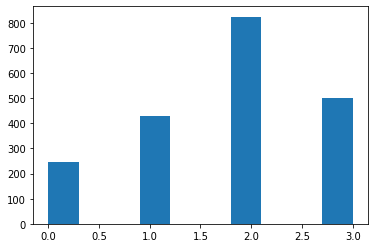

In [18]:
plt.hist(y_pred)

In [19]:
# confusion matrix
confusion_matrix(y-1, y_pred-1)


array([[220,  27,   0,   0],
       [ 26, 359,  41,   0],
       [  0,  42, 752,  31],
       [  0,   0,  31, 471]])

In [20]:
# accuracy
round(accuracy_score(y_true=y, y_pred=y_pred),2)

0.9